In [1229]:
# import pandas as pd
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# from torch.utils.data import Dataset, DataLoader
# from matplotlib.dates import datestr2num
# import torch.optim as optim
# from sklearn import preprocessing
# import math

In [1384]:
FILENAME = 'daytabase_no_shuffle.csv'

BATCH_SIZE = 32
TRAIN_SPLIT = 0.95

NUM_POINTS_PER_ENTRY = 150
NUM_FEATURES = 3*NUM_POINTS_PER_ENTRY
NUM_UNITS = 512
NUM_USERS = 9
NUM_EPOCHS = 30

EPSILON = 0.1
DELTA = 10**-5
NORM_CLIP=10

SIGMA = 0

RHO = 1.0

UTILITY_WEIGHTS = (2,2,2,2)
PRIVACY_WEIGHTS =(2,1)

MAP_PARAMS = 2

NUM_GRIDS = 4

## Load Data

In [1385]:
class ChaniaDataset(Dataset):
    def __init__(self, csv_file, transform=None, normalize=True):
#         
        self.augmented_data = pd.read_csv(csv_file, usecols = [0]+list(range(2,NUM_FEATURES+1)))
        self.userlabels = pd.read_csv(csv_file, usecols=[0])
        self.transform = transform
        
        if normalize:
            self.augmented_data=(self.augmented_data-self.augmented_data.mean())/self.augmented_data.std()

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        data = self.augmented_data.iloc[idx].values
        data = data.astype('float').reshape(-1,NUM_FEATURES)            
        user = self.userlabels.iloc[idx].values
        user = user.astype('int').reshape(-1,1)
        sample = {'x':data, 'u':user}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [1386]:
class ToTensor(object):
    def __call__(self, sample):
        data, user = sample['x'], sample['u']
        return {'x':torch.from_numpy(data), 'u':torch.from_numpy(user)}

In [1387]:
chania_dataset = ChaniaDataset(csv_file=FILENAME, transform=ToTensor(), normalize=True)

In [1388]:
train_size=int(TRAIN_SPLIT*len(chania_dataset))
test_size = len(chania_dataset)-train_size

In [1389]:
train_dataset, test_dataset = torch.utils.data.random_split(chania_dataset, [train_size, test_size])

In [1390]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Visualize Functions

In [1391]:
def show_privatizer(x, y, u, uhat):
    with torch.no_grad():
        fig, ax = plt.subplots(1,3,figsize=(15,5))
        #sharex=True,sharey=True,
        ax[0].set_title("Input Data")
        ax[1].set_title("Obfuscated Data")
        ax[2].set_title("Adversary Estimate")
        _, upred = torch.max(uhat.data,1)
        for i in range(NUM_POINTS_PER_ENTRY):
            ax[0].scatter(x[:,:,2+3*i].numpy(),x[:,:,1+3*i].numpy(),c=u.unsqueeze(0).numpy().T.tolist())
            ax[1].scatter(y[:,:,2+3*i].numpy(),y[:,:,1+3*i].numpy(),c='black')
            ax[2].scatter(y[:,:,2+3*i].numpy(),y[:,:,1+3*i].numpy(),c=upred.numpy().reshape(-1,1).tolist())

In [1392]:
def show_maps(x, y,npoints=100):
    with torch.no_grad():
        fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(15,5))
        ax[0].set_title("Map from Input Data")
        ax[1].set_title("Map from Obfuscated Data")
        
        grid = torch.empty(npoints,1,2).uniform_(5)-2.5
        tr = [grid[:,:,1]**i*grid[:,:,0]**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)]
        poly_grid = torch.cat(tr,1)
        poly_grid = poly_grid.view(-1,6)
        
        bx = signal_map_params(x,MAP_PARAMS).float()
        by = signal_map_params(y,MAP_PARAMS).float()  
        x_predicted_rss = torch.mm(poly_grid,bx)
        y_predicted_rss = torch.mm(poly_grid,by)
        
        ax[0].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=x_predicted_rss.numpy())
        ax[1].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=y_predicted_rss.numpy())

## Define loss and helper functions

In [1393]:
def privatizer_loss(x,y,u,uhat):
    bx = signal_map_params(x,MAP_PARAMS)
    by = signal_map_params(y,MAP_PARAMS)
    l1 = (bx-by).pow(2).mean()
    l2 = (x-y).pow(2).mean()
    l3 = (y[:,:,[1+3*i for i in range(NUM_POINTS_PER_ENTRY)] + [2+3*i for i in range(NUM_POINTS_PER_ENTRY)]]-
          x[:,:,[1+3*i for i in range(NUM_POINTS_PER_ENTRY)] + [2+3*i for i in range(NUM_POINTS_PER_ENTRY)]]).pow(2).mean() # check this power
#     cx = density_count(x,NUM_GRIDS)
#     cy = density_count(y,NUM_GRIDS)
#     l4 = (cx-cy).pow(2).mean()/(BATCH_SIZE*NUM_POINTS_PER_ENTRY)
    l = torch.nn.CrossEntropyLoss()
    l5 = l(uhat,u)
    w1,w2,w3,w4 = UTILITY_WEIGHTS
    return RHO*(w1*l1+w2*l2+w3*l3)-(1-RHO)*l5

In [1394]:
def poly(degree, long, lat):
    return torch.cat([long**i*lat**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)],1)

def signal_map_params(x,degree):    
    polynomial = poly(degree, x[:,:,[2+3*i for i in range(NUM_POINTS_PER_ENTRY)]].reshape(-1,1), 
                      x[:,:,[1+3*i for i in range(NUM_POINTS_PER_ENTRY)]].reshape(-1,1))
    beta = torch.mm(torch.inverse(torch.mm(torch.transpose(polynomial,0,1), polynomial)),
                  torch.mm(torch.transpose(polynomial,0,1), x[:,:,[0+3*i for i in range(NUM_POINTS_PER_ENTRY)]].reshape(-1,1)))
    return beta

In [1395]:
# def density_count(x, num_grids):
#     count = torch.zeros(num_grids,num_grids)
#     for i in range(NUM_POINTS_PER_ENTRY):
#         count += partial_density_count(x[:,:,i*4:(i+1)*4], num_grids)
#     return count
    

# def partial_density_count(x, num_grids):
#     count = torch.zeros(num_grids,num_grids)
#     x1min=torch.min(x[:,:,3])
#     x2min=torch.min(x[:,:,2])
#     size1 = torch.max(x[:,:,3])-x1min
#     size2 = torch.max(x[:,:,2])-x2min
#     a_all = []
#     c_all = []
#     for i in range(num_grids):
#         for j in range(num_grids):
#             a = x1min+(size1/num_grids*i)
#             a_all.append(a)
#             b = x1min+(size1/num_grids*(i+1))
#             a_all.append(b)
#             c = x2min+(size2/num_grids*j)
#             c_all.append(c)
#             d = x2min+(size2/num_grids*(j+1))
#             c_all.append(d)
#             if i == num_grids-1 and j != num_grids-1:
#                 count[i][j] += x[(x[:,:,3] >= a ) & 
#                                  (x[:,:,3] <= b) & 
#                                  (x[:,:,2] >= c) & 
#                                  (x[:,:,2] < d)].size(0)
#             elif j == num_grids-1 and i != num_grids-1:
#                 count[i][j] += x[(x[:,:,3] >= a ) & 
#                                  (x[:,:,3] < b) & 
#                                  (x[:,:,2] >= c) & 
#                                  (x[:,:,2] <= d)].size(0)
#             elif j == num_grids-1 and i == num_grids-1:
#                 count[i][j] += x[(x[:,:,3] >= a ) & 
#                                  (x[:,:,3] <= b) & 
#                                  (x[:,:,2] >= c) & 
#                                  (x[:,:,2] <= d)].size(0)
#             else:
#                 count[i][j] += x[(x[:,:,3] >= a ) & 
#                                  (x[:,:,3] < b) & 
#                                  (x[:,:,2] >= c) & 
#                                  (x[:,:,2] < d)].size(0)
#     return count

In [1396]:
def adversary_loss(u,uhat):
    l = torch.nn.CrossEntropyLoss()
    return l(uhat,u)

## Define privatizers

#### GAP

In [1457]:
gap_privatizer = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_FEATURES)
)
# gap_privatizer.apply(init_weights)
gap_privatizer.double()
gap_privatizer_optimizer = optim.Adam(gap_privatizer.parameters(),lr=0.001, betas=(0.9,0.999))

In [1458]:
# gap_privatizer = torch.nn.Sequential(
#     torch.nn.Linear(NUM_FEATURES, 512),
#     torch.nn.ReLU(),
#     torch.nn.Linear(512, 128),
#     torch.nn.ReLU(),
#     torch.nn.Linear(128, 128),
#     torch.nn.ReLU(),
# #     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
# #     torch.nn.ReLU(),
#     torch.nn.Linear(128, NUM_FEATURES)
# )
# # gap_privatizer.apply(init_weights)
# gap_privatizer.double()
# gap_privatizer_optimizer = optim.Adam(gap_privatizer.parameters(),lr=0.001, betas=(0.9,0.999))

#### Local DP

In [1459]:
def dp_privatizer(x):
    normvec = torch.norm(x,p=2,dim=2)
    scalevec = NORM_CLIP/normvec
    scalevec[scalevec>1] = 1
    x = torch.transpose(torch.transpose(x,0,1)*scalevec,0,1).double()
    sigma = (NORM_CLIP/EPSILON)*math.sqrt(2*math.log(1.25/DELTA))
    noise = torch.normal(mean=torch.zeros_like(x),std=sigma).double()
    y = x + noise
    return y

#### Gaussian Noise

In [1460]:
def noise_privatizer(x):
    noise = torch.normal(mean=torch.zeros_like(x),std=SIGMA).double()
    y = x + noise
    return y

## Define adversary

512, 128, 0.01, 33%  
256, 128, 32, 43% no bias  
256, 128, 32, 46% bias 0.1  
256, 128, 32, 53% bias 0.25, 0.1  
256, 128, 32, 56% bias 0.25, 0.1, lr 0.001

In [1461]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=0.01)
        torch.nn.init.normal_(m.bias, mean=0.25, std=0.1)
#         m.bias.data.fill_(-1)

In [1462]:
# adversary = torch.nn.Sequential(
#     torch.nn.Linear(NUM_FEATURES, 128),
#     torch.nn.ReLU(),
#     torch.nn.Linear(128, 64),
#     torch.nn.ReLU(),
#     torch.nn.Linear(64, 32),
#     torch.nn.ReLU(),
# #     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
# #     torch.nn.ReLU(),
#     torch.nn.Linear(32, NUM_USERS)
# )
# adversary.apply(init_weights)
# adversary.double()

In [1463]:
adversary = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
    torch.nn.Linear(128, NUM_USERS)
)
adversary.apply(init_weights)
adversary.double()

Sequential(
  (0): Linear(in_features=450, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=9, bias=True)
)

In [1464]:
adversary_optimizer = optim.Adam(adversary.parameters(),lr=0.001, betas=(0.9,0.999))

# TRAIN

In [1465]:
PRIVATIZER = gap_privatizer

In [1466]:
# for each epoch
for epoch in range(NUM_EPOCHS):
    
    # iterate through the training dataset
    for i, batch in enumerate(train_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        if PRIVATIZER == gap_privatizer:
            # reset privatizer gradients
            gap_privatizer_optimizer.zero_grad()
        
        # privatize x
        y = PRIVATIZER(x)
        
        # reset adversary gradients
        adversary_optimizer.zero_grad()
        
        # estimate userIDs and original locations
        uhat = adversary(y).squeeze()
        
        # train adversary
        aloss = adversary_loss(u,uhat)
        aloss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(adversary.parameters(), 1000)
        adversary_optimizer.step()
        
        # evaluate utility loss
        ploss = privatizer_loss(x,y,u,uhat)
        
        if PRIVATIZER == gap_privatizer:
            # train privatizer
            ploss.backward()
            # check that gradients are non-zero
            # for param in gap_privatizer.parameters():
                # print(param.grad)
            torch.nn.utils.clip_grad_norm_(gap_privatizer.parameters(), 1000)
            gap_privatizer_optimizer.step()
        
        # print progress
#         if i % 10 == 9:
#             print(i+1,"aloss:",aloss.item(),"ploss:",ploss.item())
          
        # stop early
        if i == 1:
            pass
print("done")

done


# Test

In [1454]:
test_epochs = 1

for test_epoch in range(test_epochs):
    # do not keep track of gradients
    with torch.no_grad():
        correct = 0
        total = 0
        dist_error = 0
        l1,l2,l3,l4,l5 = 0,0,0,0,0

        # iterate through test data
        for i,batch in enumerate(test_loader):

            # unpack batch
            x, u = batch['x'], batch['u'].squeeze()

            # privatize x
            y = PRIVATIZER(x)

            # estimate userID and location
            estimate = adversary(x).squeeze()
            uhat, lochat = estimate[:,:9], estimate[:,9:]

            # Privacy Metric
            _, upred = torch.max(uhat.data,1)
            total+=u.size(0)
            correct+=(upred==u).sum().item()
    #         print("u:", u)
    #         print("p:",upred)
    #         print(uhat.data[0])
    #         dist_error += (x[:,:,12:14]-lochat).pow(2).mean().item()

            # Utility Metrics       
            bx = signal_map_params(x,MAP_PARAMS)
            by = signal_map_params(y,MAP_PARAMS)
            l1 = (bx-by).pow(2).mean()
            l2 = (x-y).pow(2).mean()
            l3 = (y[:,:,[1+3*i for i in range(NUM_POINTS_PER_ENTRY)] + [2+3*i for i in range(NUM_POINTS_PER_ENTRY)]]-
                  x[:,:,[1+3*i for i in range(NUM_POINTS_PER_ENTRY)] + [2+3*i for i in range(NUM_POINTS_PER_ENTRY)]]).pow(2).mean() # check this power
    #         cx = density_count(x,NUM_GRIDS)
    #         cy = density_count(y,NUM_GRIDS)
    #         l4 = (cx-cy).pow(2).mean()/(BATCH_SIZE*NUM_POINTS_PER_ENTRY)
            l = torch.nn.CrossEntropyLoss()
            l5 = l(uhat,u)

            # stop early
            if i==0:
                break

        with open("freshdaybyday.csv", "a") as fd:
            for elt in [RHO, 100*correct/total, l5.item()/(i+1), l1.item()/(i+1), l2.item()/(i+1), l3.item()/(i+1)]:
                fd.write(str(elt))
                fd.write(",")
            fd.write("\n")

        print("SIGMA = ",SIGMA)
        print("RHO = ", RHO)
        print("Adversary Accuracy:", 100*correct/total)
    #     print("Average estimated location error:",dist_error/(i+1))

        print("Adversary Loss:", l5.item()/(i+1))
        print("Sigmal Map:", l1.item()/(i+1))
        print("Distortion:", l2.item()/(i+1))
        print("Geographic Distortion:", l3.item()/(i+1))
    #     print("Density Count:",l4.item()/(i+1))

SIGMA =  0
RHO =  1.0
Adversary Accuracy: 12.5
Adversary Loss: 82.20441799475601
Sigmal Map: 0.04360191591686699
Distortion: 0.9512893908503514
Geographic Distortion: 0.972221955973875


# Visualize

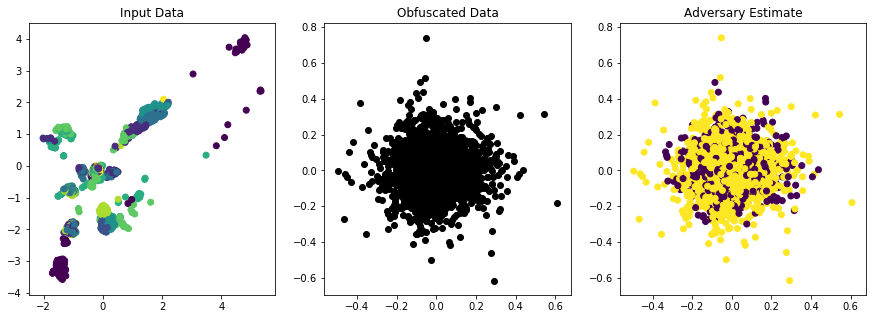

In [1455]:
show_privatizer(x,y,u,uhat)

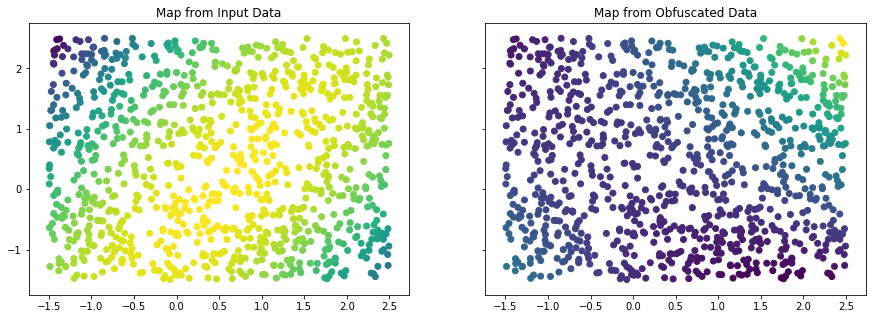

In [1456]:
show_maps(x,y,1000)